Lastly, we would like to plot the prices information on a map, ideally interactive map;

We need to extract latitude (Lat) and longitude (Lon) information from our downloaded data;

With the Lat/Lon information we can then plot the resale prices on the map using the prices per square meters.

In [2]:
import numpy as np
import pandas as pd
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
import shapefile as shp

In [10]:
df = pd.read_pickle("data_w_postal.pkl")

In [11]:
df['Price_per_sqm'] = df['resale_price']/df['floor_area_sqm']

In [112]:
df.tail()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Postal_code,Price_per_sqm,X,Y
62260,2019-11,YISHUN,5 ROOM,865,YISHUN ST 81,07 TO 09,122.0,Improved,1988,67 years 05 months,458000.0,760865,3754.098361,28549.903194,44008.041034
62261,2019-11,YISHUN,EXECUTIVE,328,YISHUN RING RD,07 TO 09,142.0,Apartment,1988,67 years 08 months,565000.0,760328,3978.873239,29083.732600,45723.276519
62262,2019-11,YISHUN,EXECUTIVE,328,YISHUN RING RD,04 TO 06,146.0,Maisonette,1988,67 years 07 months,538000.0,760328,3684.931507,29083.732600,45723.276519
62263,2019-11,YISHUN,EXECUTIVE,611,YISHUN ST 61,10 TO 12,146.0,Maisonette,1987,67 years,588888.0,760611,4033.479452,28315.417911,44664.111870
62264,2019-11,YISHUN,EXECUTIVE,828,YISHUN ST 81,04 TO 06,145.0,Apartment,1988,67 years 02 months,618000.0,760828,4262.068966,27953.606541,44110.138999


In [14]:
# We would like to create a dictionary using postal code as key and each key maps to a different dictionary using Lat and Lon as key, storing Latitude and Longitude for that postal code location

postal_X = defaultdict()
postal_Y = defaultdict()
url_used = []
house_info = []
failure = []

with open('success_house.txt','r') as f:
    for line in f:
        try:
            details = json.loads(line.split('"text":')[1][:-2])
            house_info.append(details)
            key = details['results'][0]['POSTAL']
            x = details['results'][0]["X"]
            y = details['results'][0]["Y"]
            postal_X[key] = x
            postal_Y[key] = y
            url = line.split('"text":')[0][8:-2]
            url_used.append(url)
        except IndexError:
            url = line.split('"text":')[0][8:-2]
            failure.append(url)
        

In [15]:
postal_code_fix = ['680215','540238','730721','730729','730749','330097']

x_fix = [18407.291240000002,35272.090939999995,24337.18742,24134.224130000002,23676.64731,32109.41893]
y_fix = [40539.04137,41373.41621,47306.45276,47139.8793,47354.8459,33998.94239]

In [16]:
for key,x,y in zip(postal_code_fix,x_fix,y_fix):
    postal_X[key] = x
    postal_Y[key] = y

In [18]:
df['X'] = df['Postal_code'].replace(postal_X)

In [19]:
df['Y'] = df['Postal_code'].replace(postal_Y)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62265 entries, 0 to 62264
Data columns (total 15 columns):
month                  62265 non-null object
town                   62265 non-null object
flat_type              62265 non-null object
block                  62265 non-null object
street_name            62265 non-null object
storey_range           62265 non-null object
floor_area_sqm         62265 non-null float64
flat_model             62265 non-null object
lease_commence_date    62265 non-null int64
remaining_lease        62265 non-null object
resale_price           62265 non-null float64
Postal_code            62265 non-null object
Price_per_sqm          62265 non-null float64
X                      62265 non-null float64
Y                      62265 non-null float64
dtypes: float64(5), int64(1), object(9)
memory usage: 7.1+ MB


In [21]:
ylim = (min(df.Y),max(df.Y))
xlim = (min(df.X),max(df.X))

In [22]:
ylim

(28097.635137058798, 48695.325465451904)

In [23]:
xlim

(11519.1464938996, 45192.2992945584)

In [24]:
len_xlim = xlim[1]-xlim[0]
len_ylim = ylim[1]-ylim[0]

In [25]:
len_xlim/len_ylim

1.6348023620027767

In [28]:
#bar labels are added after the log transformation; the bar_label list is the log(price)
bar_label = [7.8,8,8.2,8.4,8.6,8.8,9,9.2]
bar_label_e = [np.e**num for num in bar_label]
bar_labels = ["{:,.0f}".format(num) for num in bar_label_e]

<IPython.core.display.Javascript object>


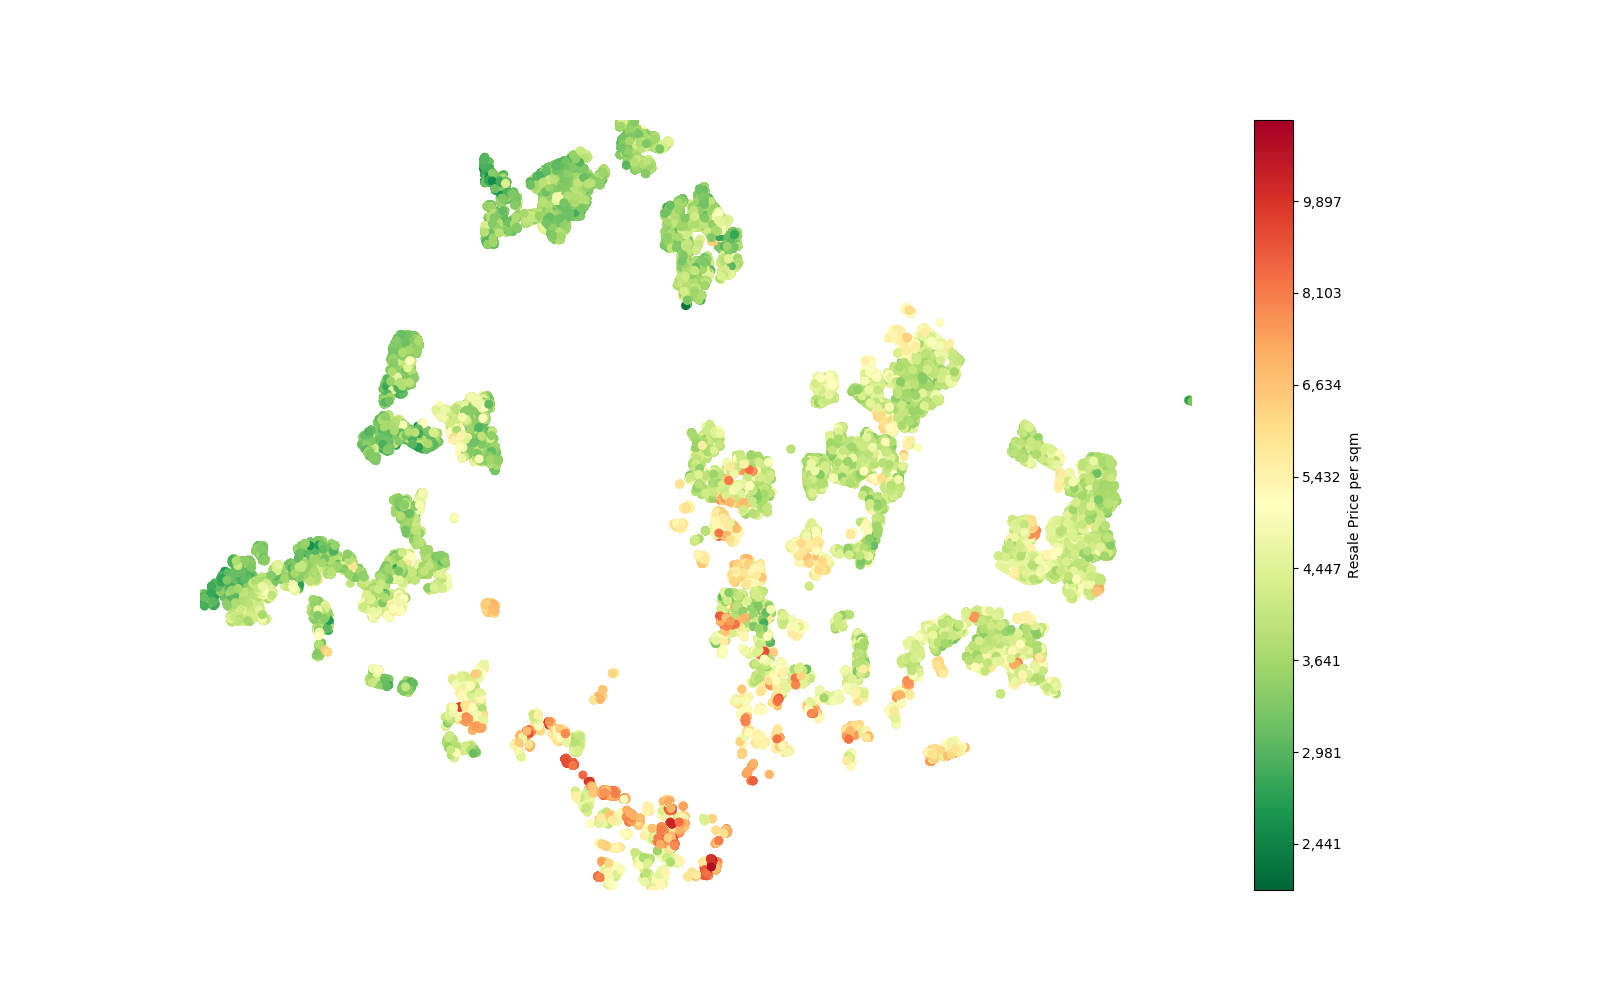

Text(0, 0.5, 'Resale Price per sqm')

In [29]:
# Plot using latitude as y and longitude as x

cmap = matplotlib.cm.RdYlGn_r # replace with your favourite colormap 
fig, ax = plt.subplots(figsize=(16,10))
s = ax.scatter(df.X, df.Y, s=30,c=np.log(df.Price_per_sqm), cmap=cmap)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_frame_on(False)
ax.set_yticklabels("")
ax.set_xticklabels("")
ax.tick_params(axis = u'both', which=u'both',length=0)

#Adding color bar 
cbar = fig.colorbar(s)
cbar.ax.set_yticklabels(bar_labels)
cbar.ax.set_ylabel('Resale Price per sqm')

We will follow the instruction found here to create a Singapore map using the shape file;
Reference: https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

In [30]:
shp_path = 'G:\Github\Investigating_Singapore_Housing_Price\master-plan-2014-planning-area-boundary-no-sea-shp\MP14_PLNG_AREA_NO_SEA_PL.shp'
sf = shp.Reader(shp_path)

In [31]:
len(sf.shapes())

55

There are 55 records in the shape file of Singapore's

Let's check how many HDB town there are

In [32]:
len(df.town.unique())

26

It looks like HDB towns are less than planning area. Let's first extract all the names of planning area first

In [33]:
sf.records()[1]

Record #1: [2, 'BEDOK', 'BD', 'N', 'EAST REGION', 'ER', '1719251260799DF6', datetime.date(2016, 5, 11), 38582.665, 34032.0961, 21872.7989616, 21733187.7807]

In [34]:
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['OBJECTID', 'N', 9, 0],
 ['PLN_AREA_N', 'C', 30, 0],
 ['PLN_AREA_C', 'C', 2, 0],
 ['CA_IND', 'C', 1, 0],
 ['REGION_N', 'C', 30, 0],
 ['REGION_C', 'C', 3, 0],
 ['INC_CRC', 'C', 50, 0],
 ['FMEL_UPD_D', 'D', 8, 0],
 ['X_ADDR', 'F', 19, 11],
 ['Y_ADDR', 'F', 19, 11],
 ['SHAPE_Leng', 'F', 19, 11],
 ['SHAPE_Area', 'F', 19, 11]]

shapefile.Reader

Convert data to Pandas Dataframe

In [35]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [36]:
df_shape = read_shapefile(sf)

In [111]:
df_shape

,OBJECTID,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,Y_ADDR,SHAPE_Leng,SHAPE_Area,coords
0,1,ANG MO KIO,AM,N,NORTH-EAST REGION,NER,E5CBDDE0C2113055,2016-05-11,28976.8763,40229.1238,17494.240190,1.394138e+07,"[(30658.50009999983, 42047.52720000036), (3067..."
1,2,BEDOK,BD,N,EAST REGION,ER,1719251260799DF6,2016-05-11,38582.6650,34032.0961,21872.798962,2.173319e+07,"[(38974.26939999964, 36138.243300000206), (393..."
2,3,BISHAN,BS,N,CENTRAL REGION,CR,BA616285F402846F,2016-05-11,28789.7630,37450.8865,13517.121556,7.618921e+06,"[(29772.191399999894, 38311.80470000021), (297..."
3,4,BOON LAY,BL,N,WEST REGION,WR,A3DC87118B43CDED,2016-05-11,13410.3824,33008.9884,18528.467448,8.279408e+06,"[(12861.382899999619, 32207.49230000004), (128..."
4,5,BUKIT BATOK,BK,N,WEST REGION,WR,FB44C870B04B7F57,2016-05-11,19255.4150,37527.6527,15234.223423,1.113326e+07,"[(20294.455199999735, 39114.52789999917), (203..."
5,6,BUKIT MERAH,BM,N,CENTRAL REGION,CR,738B479882E4EE28,2016-05-11,26865.7838,28662.8732,29156.293788,1.446247e+07,"[(26228.631000000052, 30746.197000000626), (26..."
6,7,BUKIT PANJANG,BP,N,WEST REGION,WR,4A9C6E6BAF7BE998,2016-05-11,21287.0436,38761.8448,15891.853279,9.019940e+06,"[(21448.724000000395, 41356.74139999971), (215..."
7,8,BUKIT TIMAH,BT,N,CENTRAL REGION,CR,C893AEAD20F42559,2016-05-11,23256.7643,34689.0037,22492.840844,1.752665e+07,"[(24031.386500000022, 36694.74220000021), (240..."
8,9,GEYLANG,GL,N,CENTRAL REGION,CR,957AC76DACFDE12E,2016-05-11,34255.0407,33683.8190,12959.116844,9.643156e+06,"[(35619.753999999724, 32450.585899999365), (35..."
9,10,KALLANG,KL,N,CENTRAL REGION,CR,229F1481FF686959,2016-05-11,31685.3730,32515.7735,15584.137724,9.169902e+06,"[(31277.372800000012, 34723.2929999996), (3130..."


In [87]:
sf.records()[0][1]

'ANG MO KIO'

Column PLN_AREA_N stores the name of the planning area, we can see that there are some areas may not have any HDB built. We will check later with visualization

In [65]:
region_names = list(df_shape.PLN_AREA_N)
X_addr = list(df_shape.X_ADDR)
Y_addr = list(df_shape.Y_ADDR)
xlim_2 = (10000,45000)
ylim_2 = (26000,50000)

In [98]:
unwanted_region = ['NORTH-EASTERN ISLANDS','WESTERN ISLANDS','SOUTHERN ISLANDS','TUAS','CHANGI BAY','NEWTON','SINGAPORE RIVER','MUSEUM','ORCHARD']
region_keep = [region for region in region_names if region not in unwanted_region]

Below is the heat map for transaction prices

<IPython.core.display.Javascript object>


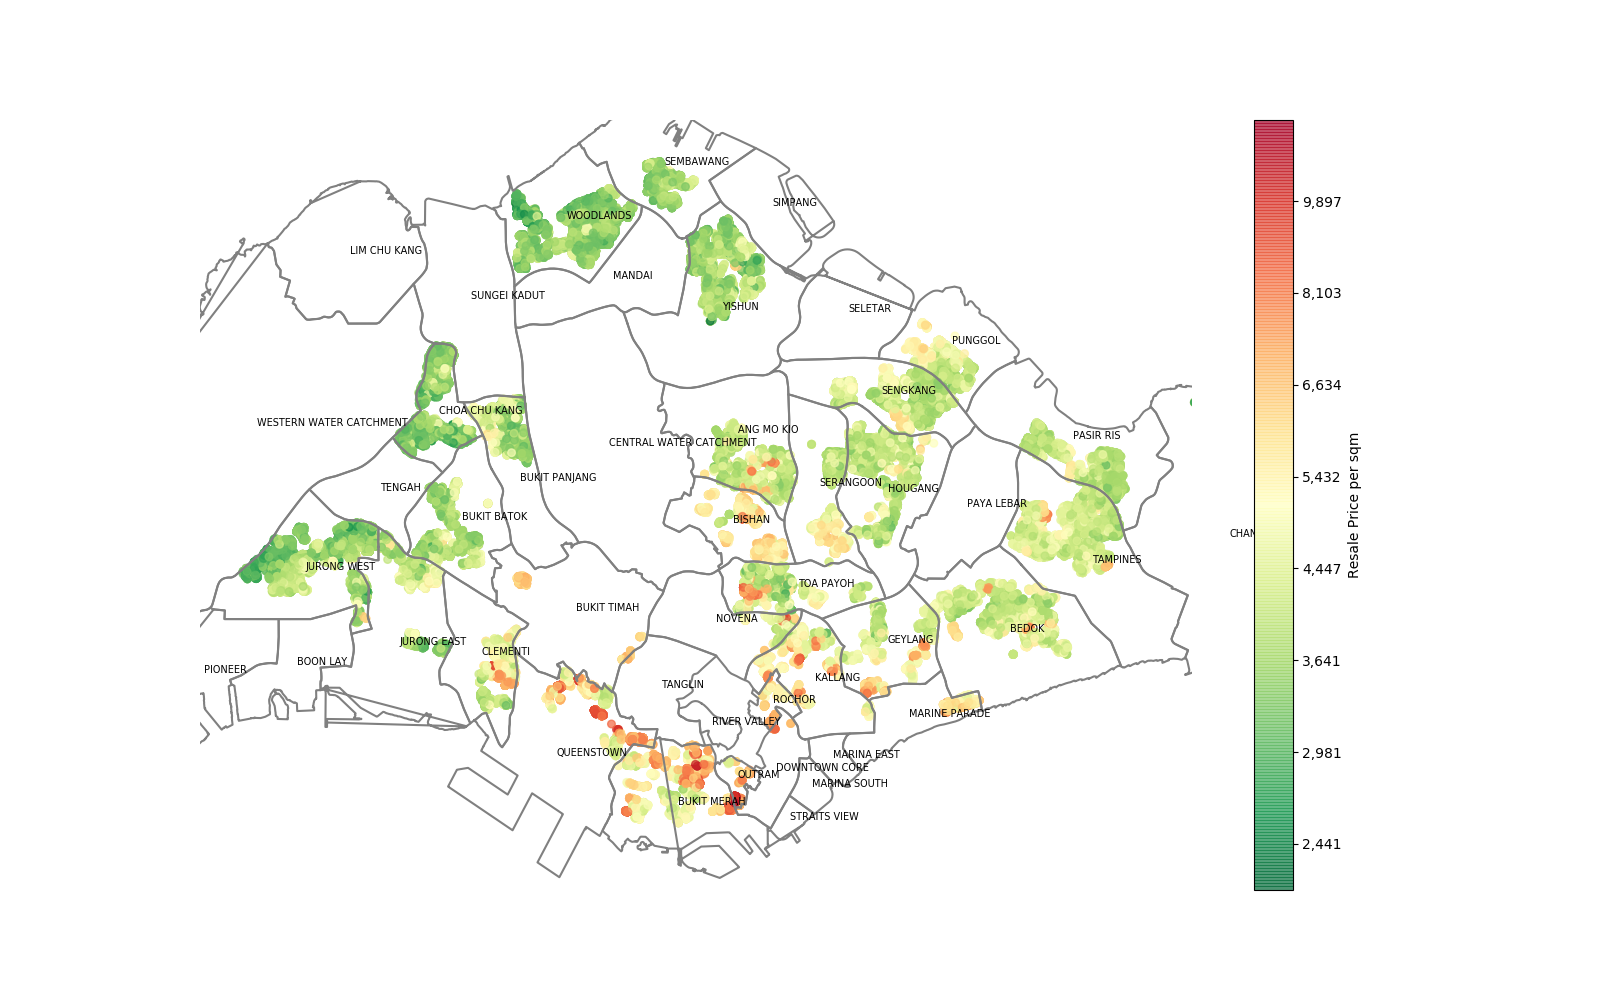

In [128]:
fig, ax = plt.subplots(figsize=(16,10))
cmap = matplotlib.cm.RdYlGn_r

id=0
for shape in sf.shapeRecords():
    if shape.record[1] in region_keep:
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'grey')

        x0 =shape.record[8]
        y0 = shape.record[9]
        ax.text(x0, y0, shape.record[1], fontsize=7)
        id = id+1
        
ax.set_frame_on(False)
ax.set_yticklabels("")
ax.set_xticklabels("")
ax.tick_params(axis = u'both', which=u'both',length=0)
ax.set_ylim(ylim_2)
ax.set_xlim(xlim_2)
s = ax.scatter(df.X, df.Y, s=30,c=np.log(df.Price_per_sqm), cmap=cmap,alpha= 0.7)

#Adding color bar 
cbar = fig.colorbar(s)
cbar.ax.set_yticklabels(bar_labels)
cbar.ax.set_ylabel('Resale Price per sqm')
fig.savefig('first_plot2.svg')
fig.savefig('first_plot2.png')

Let's load our modela and predicted results for test set which we have saved in step 4

In [103]:
data_pre = pd.read_pickle('data_w_prediction.pkl')

In [131]:
data_pre['diff_pct'] = (data_pre.Prediction_transformed - data_pre.resale_price)/data_pre.resale_price

In [113]:
data_pre2 = data_pre.merge(df,left_index=True,right_index=True)

In [134]:
data_pre2['diff_pct'] = (data_pre2.Prediction_transformed - data_pre2.resale_price_x)/data_pre2.resale_price_x

In [135]:
data_pre2.head()

,month_x,Year,Month,town_x,flat_type_x,storey,floor_area_sqm_x,flat_model_x,Remaining_lease_years,Postal_code_x,...,floor_area_sqm_y,flat_model_y,lease_commence_date,remaining_lease,resale_price_y,Postal_code_y,Price_per_sqm,X,Y,diff_pct
50528,2019-06-01,2019,06,ANG MO KIO,1 / 2 ROOM,11,45.0,Improved,65.583333,561172,...,92.0,New Generation,1978,58 years 06 months,350000.0,460508,3804.347826,39040.024777,35066.349742,0.160226
50529,2019-06-01,2019,06,ANG MO KIO,3 ROOM,2,73.0,New Generation,57.000000,560320,...,92.0,New Generation,1979,59 years,368000.0,460095,4000.000000,40101.426805,35118.350743,0.070460
50530,2019-06-01,2019,06,ANG MO KIO,3 ROOM,8,73.0,New Generation,56.916667,560319,...,91.0,New Generation,1980,60 years 06 months,370000.0,470705,4065.934066,37534.909787,35424.190921,-0.021340
50531,2019-06-01,2019,06,ANG MO KIO,3 ROOM,8,73.0,New Generation,55.916667,560215,...,85.0,Model A,2006,85 years 09 months,563000.0,460182,6623.529412,40076.537412,34344.318159,0.078877
50532,2019-06-01,2019,06,ANG MO KIO,3 ROOM,8,67.0,New Generation,57.083333,560219,...,92.0,New Generation,1979,58 years 07 months,383000.0,460428,4163.043478,38498.131738,34639.488903,0.056442


<IPython.core.display.Javascript object>


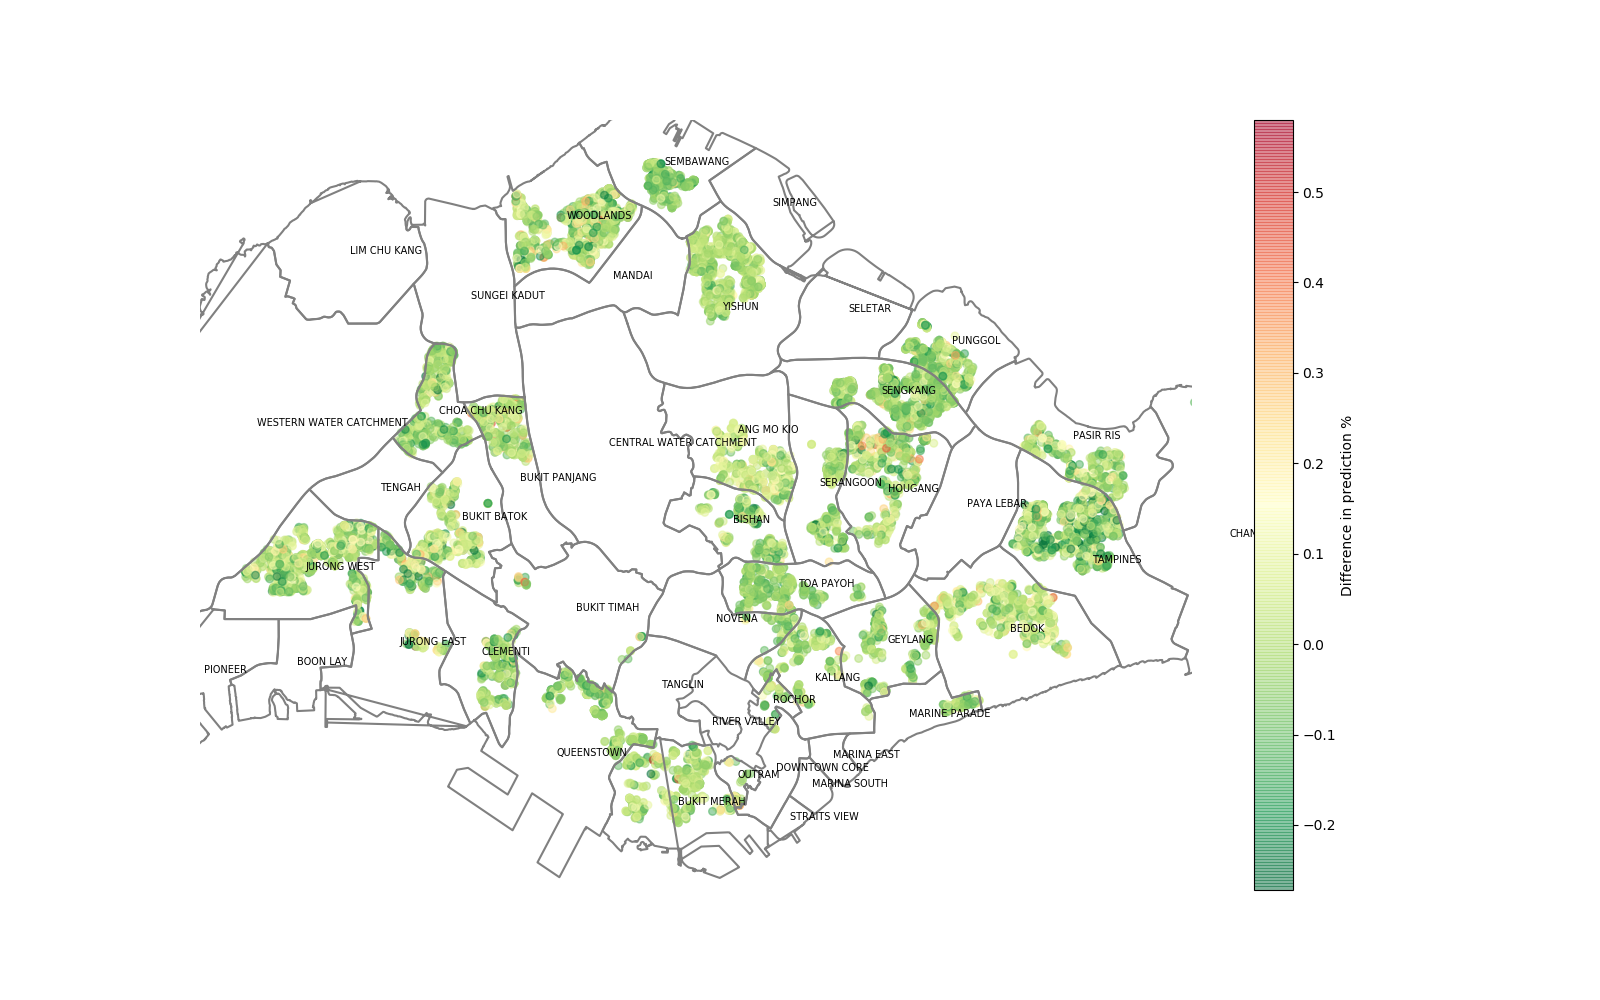

In [141]:
fig, ax = plt.subplots(figsize=(16,10))
cmap = matplotlib.cm.RdYlGn_r

id=0
for shape in sf.shapeRecords():
    if shape.record[1] in region_keep:
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'grey')

        x0 =shape.record[8]
        y0 = shape.record[9]
        ax.text(x0, y0, shape.record[1], fontsize=7)
        id = id+1
        
ax.set_frame_on(False)
ax.set_yticklabels("")
ax.set_xticklabels("")
ax.tick_params(axis = u'both', which=u'both',length=0)
ax.set_ylim(ylim_2)
ax.set_xlim(xlim_2)
s = ax.scatter(data_pre2.X, data_pre2.Y, s=30,c=data_pre2.diff_pct,cmap=cmap,alpha=0.5)

#Adding color bar 
cbar = fig.colorbar(s)
#cbar.ax.set_yticklabels(bar_labels)
cbar.ax.set_ylabel('Difference in prediction %')
fig.savefig('prediction_plot.svg')
fig.savefig('prediction_plot.png')

We have plotted the difference in prediction. The color is in scale